In [ ]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict

class Level2(Client):
    K=5
    Bids = {} # Prices and volumes of bids
    Asks = {} # Prices and volumes of asks
    reference_price = None
    first_bid = None # Best Bid
    first_ask = None # Best Ask
    
    total_event_sizes = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    numbers_of_events = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])

    # Displays AES at each i
    def display_AES(self):
        print("Average Event Sizes (AES):")
        for i in range(-self.K,self.K+1):
            if i != 0:
                total_event_size = self.total_event_sizes[i]
                n = self.numbers_of_events[i]
                if n == 0:
                    AES = 0
                else:
                    AES = total_event_size / n
                print("Level: {}, n = {}, AES: {}".format(i, n, AES))
        print("\n")
    
    # Displays Order Book
    def display_order_book(self):
        bids = self.Bids.items()
        bids = [b for b in bids if (self.reference_price - b[0]) < self.K]
        bid_prices = [b[0] for b in bids]
        bid_volumes = [b[1] for b in bids]

        asks = self.Asks.items()
        asks = [a for a in asks if (a[0] - self.reference_price) < self.K]
        ask_prices = [a[0] for a in asks]
        ask_volumes = [a[1] for a in asks]
        
        b1 = plt.bar(bid_prices, bid_volumes, color='r')
        b2 = plt.bar(ask_prices, ask_volumes, color='g')
        v = plt.axvline(x=self.reference_price, color='b')
        plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])
        
        plt.title('ETC-USD Limit Order Book: Depth = {}'.format(self.K))
        plt.legend(['Reference Price = {}'.format(self.reference_price), 'Bids', 'Asks'])
        plt.xlabel('Price (USD Cents)')
        plt.ylabel('Volume')
        plt.show()
    
    # Updates the reference price of order book
    def update_order_book(self):
        sorted_bids = list(reversed(sorted(self.Bids.items())))
        sorted_asks = list(sorted(self.Asks.items()))        
        best_bid = sorted_bids[0]
        best_ask = sorted_asks[0]
        if ((best_bid[0] + best_ask[0]) % 2) != 0:
            self.reference_price = round((best_bid[0]+best_ask[0])/2, 1)
        else:
            self.reference_price = round((best_bid[0]+best_ask[0])/2 + 0.5,1)  
            
        self.first_bid = int(round(self.reference_price - 0.5))
        self.first_ask = int(round(self.reference_price + 0.5))
    
    # Prints LOB
    def print_order_book(self):
        print("Reference Price: {}".format(self.reference_price))
        print("---------------------------------------")
        
        print("First {} Bids: ".format(self.K))
        for price in range(self.first_bid - self.K + 1, self.first_bid + 1):
            print("{}, {}".format(price, self.Bids.get(price, 0)))
        print("---------------------------------------")
        
        print("First {} Asks: ".format(self.K))
        for price in range(self.first_ask, self.first_ask + self.K):
            print("{}, {}".format(price, self.Asks.get(price, 0)))
        print("---------------------------------------")
     
    # Receives message from API websocket
    def on_message(self, message):
        # Get snapshot of LOB from API and build internal representation
        if message['type'] == 'snapshot':
            for price, amount in message['bids']:
                self.Bids[int(round((float(price)*100)))] = float(amount)
            for price, amount in message['asks']:
                self.Asks[int(round((float(price)*100)))] = float(amount)
            self.update_order_book()
            self.display_order_book()
            self.print_order_book()
            
        # Update order book when new event occurs
        if message['type'] == 'l2update' and 'time' in message:
            significant_order = False
            for (side, price, amount) in message['changes']:
                print("Update: {}".format((side, price, amount)))
                print("Time: {}".format(message['time']))
                print("---------------------------------------")
                
                # Find i from the price. Keep track of event if
                # abs(i) <= K
                price = int(round((float(price)*100)))  
                i = price - self.reference_price
                if i < 0:
                    i = int(round(i - 0.5))
                else:
                    i = int(round(i + 0.5))
                if abs(i) <= self.K:
                    if i < 0:
                        change = float(amount) - self.Bids[price]
                    else:
                        change = float(amount) - self.Asks[price]
                    self.total_event_sizes[i] += abs(change)
                    self.numbers_of_events[i] += 1
                    significant_order = True
                    
                # Update volume in order book    
                if side == "buy":
                    if amount == "0":
                        del self.Bids[price]
                    else:
                        self.Bids[price] = float(amount)
                elif side == "sell":
                    if amount == "0":
                        del self.Asks[price]
                    else:
                        self.Asks[price] = float(amount)
                        
            # Update reference price if needed   
            self.update_order_book()
            
            if significant_order:
                # self.print_order_book()
                # self.display_AES()
                
            
            
loop = asyncio.get_event_loop()
channel = Channel('level2', 'ETC-USD')
ws = Level2(loop, channel)

try:
    loop.run_forever()
except KeyboardInterrupt:
    loop.run_until_complete(ws.close())
    loop.close()


# Try number 2

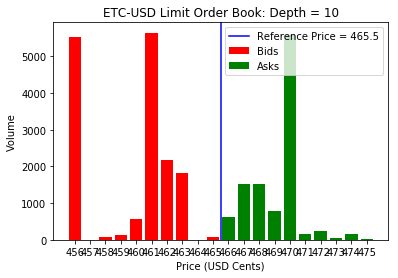

Reference Price: 465.5
---------------------------------------
First 10 Bids: 
456, 5524.82922456
457, 7.45581013
458, 74.75914291
459, 124.39629587
460, 579.77500248
461, 5640.70220475
462, 2172.81267109
463, 1807.55989138
464, 7.21
465, 69.90932
---------------------------------------
First 10 Asks: 
466, 634.62464737
467, 1529.8965
468, 1515.1893143
469, 777.56351188
470, 5568.0265
471, 159.85936348
472, 241.33427583
473, 55.86115591
474, 153.0265
475, 18.4665
---------------------------------------


Update: ('sell', '4.67000000', '1274.5965')
Time: 2018-12-21T08:45:51.422Z
---------------------------------------
Reference Price: 465.5
---------------------------------------
First 10 Bids: 
456, 5524.82922456
457, 7.45581013
458, 74.75914291
459, 124.39629587
460, 579.77500248
461, 5640.70220475
462, 2172.81267109
463, 1807.55989138
464, 7.21
465, 69.90932
---------------------------------------
First 10 Asks: 
466, 634.62464737
467, 1274.5965
468, 1515.1893143
469, 777.56351188
47

In [1]:
import asyncio
from copra.websocket import Channel, Client
import matplotlib.pyplot as plt
from collections import OrderedDict
from time import sleep
from dateutil import parser

class Level2(Client):
    K=10
    Bids = {} # Prices and volumes of bids
    Asks = {} # Prices and volumes of asks
    reference_price = None
    first_bid = None # Best Bid
    first_ask = None # Best Ask
    
    shortened_book = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    
    total_event_sizes = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    numbers_of_events = OrderedDict([(i,0) for i in range(-K,K+1) if i != 0])
    
    updates = []    

    # Displays AES at each i
    def display_AES(self):
        print("Average Event Sizes (AES):")
        for i in range(-self.K,self.K+1):
            if i != 0:
                total_event_size = self.total_event_sizes[i]
                n = self.numbers_of_events[i]
                if n == 0:
                    AES = 0
                else:
                    AES = total_event_size / n
                print("Level: {}, n = {}, AES: {}".format(i, n, AES))
        print("\n")
    
    # Displays Order Book
    def display_order_book(self):
        bids = self.Bids.items()
        bids = [b for b in bids if (self.reference_price - b[0]) < self.K]
        bid_prices = [b[0] for b in bids]
        bid_volumes = [b[1] for b in bids]

        asks = self.Asks.items()
        asks = [a for a in asks if (a[0] - self.reference_price) < self.K]
        ask_prices = [a[0] for a in asks]
        ask_volumes = [a[1] for a in asks]
        
        b1 = plt.bar(bid_prices, bid_volumes, color='r')
        b2 = plt.bar(ask_prices, ask_volumes, color='g')
        v = plt.axvline(x=self.reference_price, color='b')
        plt.xticks([x for x in range(min(bid_prices), max(ask_prices)+1)])
        
        plt.title('ETC-USD Limit Order Book: Depth = {}'.format(self.K))
        plt.legend(['Reference Price = {}'.format(self.reference_price), 'Bids', 'Asks'])
        plt.xlabel('Price (USD Cents)')
        plt.ylabel('Volume')
        plt.show()
    
    # Updates the reference price of order book
    def update_order_book(self):
        sorted_bids = list(reversed(sorted(self.Bids.items())))
        sorted_asks = list(sorted(self.Asks.items()))        
        best_bid = sorted_bids[0][0]
        best_ask = sorted_asks[0][0]
        if ((best_bid + best_ask) % 2) != 0:
            self.reference_price = round((best_bid+best_ask)/2, 1)
        else:
            middle = (best_bid+best_ask)/2
            if self.reference_price > middle:
                self.reference_price = round((best_bid+best_ask)/2 + 0.5,1)
            else:
                self.reference_price = round((best_bid+best_ask)/2 - 0.5,1)

            
        self.first_bid = int(round(self.reference_price - 0.5))
        self.first_ask = int(round(self.reference_price + 0.5))
        
        for i in range(-self.K,0):
            self.shortened_book[i] = self.Bids.get(self.first_bid + i + 1,0)
        for i in range(1,self.K+1):
            self.shortened_book[i] = self.Asks.get(self.first_ask + i - 1,0)

    
    # Prints LOB
    def print_order_book(self):
        print("Reference Price: {}".format(self.reference_price))
        print("---------------------------------------")
        
        print("First {} Bids: ".format(self.K))
        for price in range(self.first_bid - self.K + 1, self.first_bid + 1):
            print("{}, {}".format(price, self.Bids.get(price, 0)))
        print("---------------------------------------")
        
        print("First {} Asks: ".format(self.K))
        for price in range(self.first_ask, self.first_ask + self.K):
            print("{}, {}".format(price, self.Asks.get(price, 0)))
        print("---------------------------------------")
        print("\n")

     
    # Receives message from API websocket
    def on_message(self, message):
        # Get snapshot of LOB from API and build internal representation
        if message['type'] == 'snapshot':
            for price, amount in message['bids']:
                self.Bids[int(round((float(price)*100)))] = float(amount)
            for price, amount in message['asks']:
                self.Asks[int(round((float(price)*100)))] = float(amount)
            self.update_order_book()
            self.display_order_book()
            self.print_order_book()
            
        # Update order book when new event occurs
        if message['type'] == 'l2update' and 'time' in message:
            significant_order = False
            for (side, price, amount) in message['changes']:
                print("Update: {}".format((side, price, amount)))
                print("Time: {}".format(message['time']))
                print("---------------------------------------")
                
                # Find i from the price. Keep track of event if
                # abs(i) <= K
                price = int(round((float(price)*100)))  
                i = price - self.reference_price
                if i < 0:
                    i = int(round(i - 0.5))
                else:
                    i = int(round(i + 0.5))
                if abs(i) <= self.K:
                    if i < 0:
                        change = float(amount) - self.Bids[price]
                    else:
                        change = float(amount) - self.Asks[price]
                    self.total_event_sizes[i] += abs(change)
                    self.numbers_of_events[i] += 1
                    significant_order = True
                    
                    self.updates.append({
                        'reference_price': self.reference_price,
                        'LOB': self.shortened_book,
                        'K': i,
                        'change': change,
                        'time': parser.parse(message['time'])
                    })
                    
                # Update volume in order book    
                if side == "buy":
                    if amount == "0":
                        del self.Bids[price]
                    else:
                        self.Bids[price] = float(amount)
                elif side == "sell":
                    if amount == "0":
                        del self.Asks[price]
                    else:
                        self.Asks[price] = float(amount)
                        
            # Update reference price if needed   
            self.update_order_book()
            
            if significant_order:
                pass
                #self.print_order_book()
                # self.display_AES()
            

loop = asyncio.get_event_loop()
channel = Channel('level2', 'ETC-USD')
ws = Level2(loop, channel)

async def my_task(seconds):
    global loop
    print('Collecting data for {} seconds'.format(seconds))
    await asyncio.sleep(seconds)
    await ws.close()
    return "Finished Task"


try:
    task_obj = loop.create_task(my_task(seconds=28800))
    loop.run_until_complete(task_obj)
finally:
    loop.close()
    print("Finished collecting data")

In [2]:
ws.updates


[{'K': 2,
  'LOB': OrderedDict([(-10, 5524.82922456),
               (-9, 7.45581013),
               (-8, 74.75914291),
               (-7, 124.39629587),
               (-6, 1079.77500248),
               (-5, 5140.70220475),
               (-4, 2172.81267109),
               (-3, 1703.35989138),
               (-2, 7.21),
               (-1, 69.90932),
               (1, 634.62464737),
               (2, 838.5565),
               (3, 2015.1893143),
               (4, 777.56351188),
               (5, 5568.0265),
               (6, 159.85936348),
               (7, 241.33427583),
               (8, 55.86115591),
               (9, 153.0265),
               (10, 18.4665)]),
  'change': -255.29999999999995,
  'reference_price': 465.5,
  'time': datetime.datetime(2018, 12, 21, 8, 45, 51, 422000, tzinfo=tzutc())},
 {'K': 2,
  'LOB': OrderedDict([(-10, 5524.82922456),
               (-9, 7.45581013),
               (-8, 74.75914291),
               (-7, 124.39629587),
               (-6, 